In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gender-classification-dataset/Validation/female/129861.jpg.jpg
/kaggle/input/gender-classification-dataset/Validation/female/123143.jpg.jpg
/kaggle/input/gender-classification-dataset/Validation/female/117579.jpg.jpg
/kaggle/input/gender-classification-dataset/Validation/female/118471.jpg.jpg
/kaggle/input/gender-classification-dataset/Validation/female/123802.jpg.jpg
/kaggle/input/gender-classification-dataset/Validation/female/114499.jpg.jpg
/kaggle/input/gender-classification-dataset/Validation/female/124227.jpg.jpg
/kaggle/input/gender-classification-dataset/Validation/female/119414.jpg.jpg
/kaggle/input/gender-classification-dataset/Validation/female/124843.jpg.jpg
/kaggle/input/gender-classification-dataset/Validation/female/129067.jpg.jpg
/kaggle/input/gender-classification-dataset/Validation/female/115971.jpg.jpg
/kaggle/input/gender-classification-dataset/Validation/female/131076.jpg.jpg
/kaggle/input/gender-classification-dataset/Validation/female/120059.jpg.jpg

 # Prepare Data With ImageDataGenerator

**Look Data Distrubition**

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

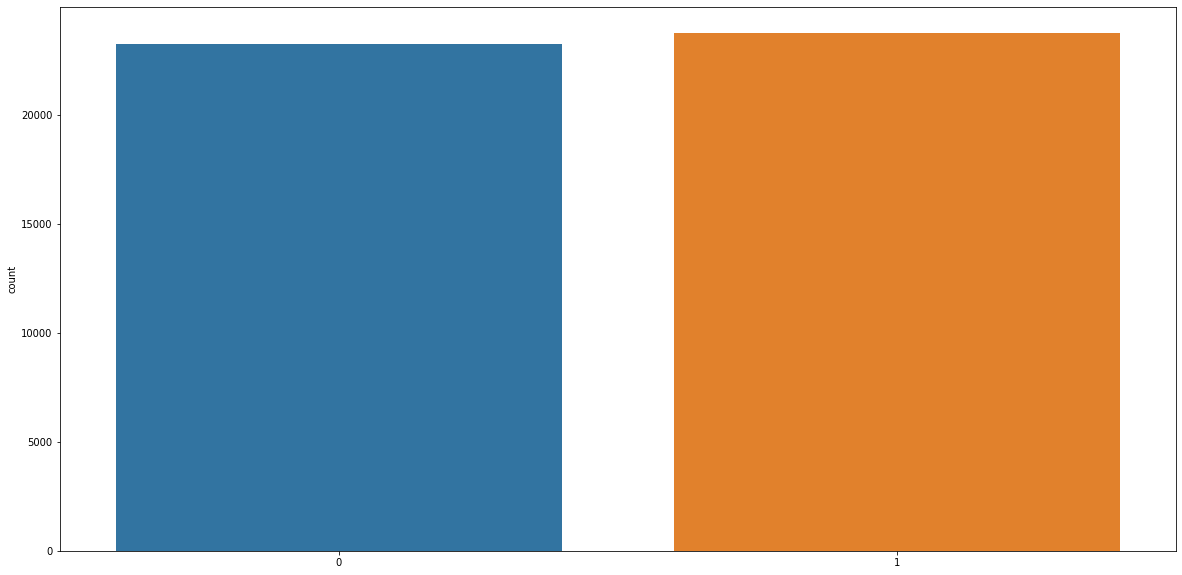

In [26]:
import matplotlib.pyplot as plt
import os 
import seaborn as sns

plt.figure(figsize=(20,10))
sns.countplot(train_data.classes)


**We'll use VGG-16 model for classification and we'll try model on some images**

In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                shear_range = 0.2,
                zoom_range = 0.2,
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                fill_mode="nearest",
                validation_split=0.15)

test_datagen = ImageDataGenerator(rescale=1./255)

In [69]:
train_data = train_datagen.flow_from_directory("../input/gender-classification-dataset/Training",
                                      target_size=(96,96),
                                       seed=123,
                                       batch_size=32,
                                       subset="training"
                                      )
val_data = train_datagen.flow_from_directory("../input/gender-classification-dataset/Training",
                                      target_size=(96,96),
                                       seed=123,
                                       batch_size=32,
                                       subset="validation"
                                      )
test_data = test_datagen.flow_from_directory("../input/gender-classification-dataset/Validation",
                                    target_size=(96,96),
                                    seed=123,
                                    batch_size=32,
                                    shuffle=False)

Found 39959 images belonging to 2 classes.
Found 7050 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


# Prepare Model

In [70]:
from tensorflow.keras.applications import VGG19

vggModel = VGG19(weights="imagenet", input_shape=(96,96,3), include_top=False)

***Let's look at VGG-16 Model Representation***

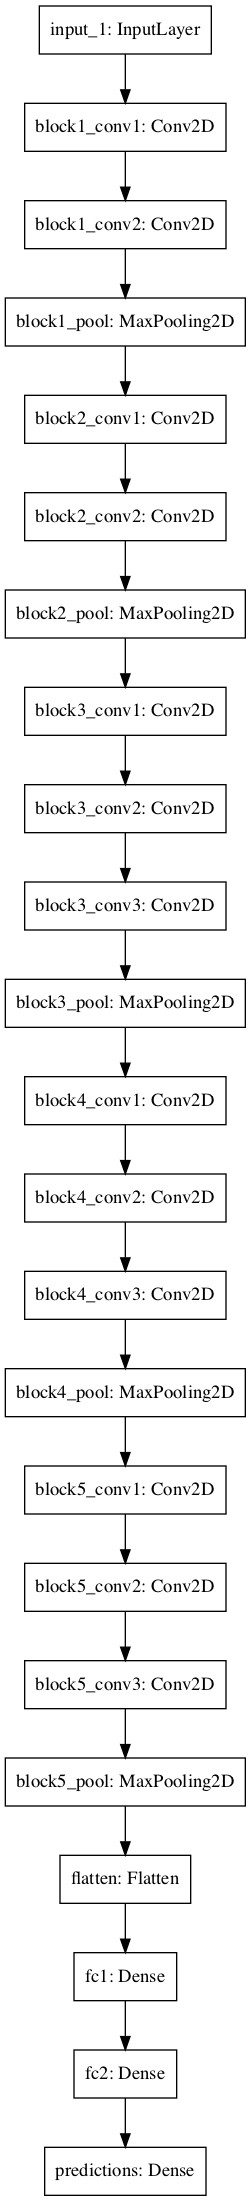

**If you are wondering how ı can implement in code , I left VGG-16 Model Structure as an image**

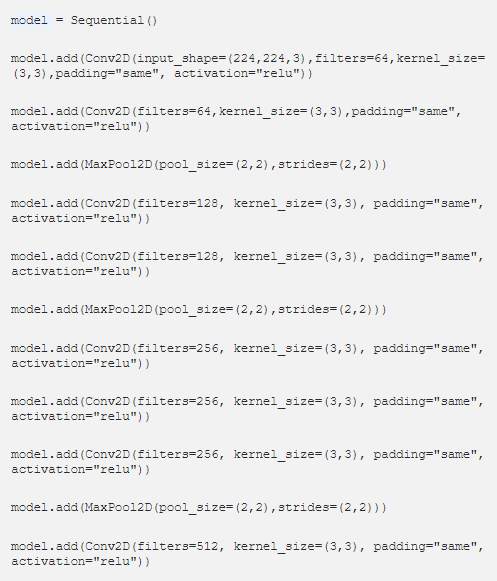

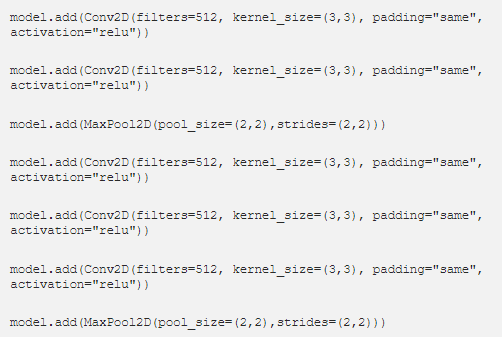

**Compile and Train VGG-16 Model**

In [71]:
for layer in vggModel.layers:
    layer.trainable = False

In [72]:
from tensorflow.keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential

model = Sequential()
model.add(vggModel)
model.add(Flatten())
model.add(Dense(units=2, activation="sigmoid"))

In [73]:
import keras
model.compile(optimizer=keras.optimizers.Adam(lr=0.01), loss = "categorical_crossentropy", metrics = ["accuracy"])

In [77]:
from keras.callbacks import EarlyStopping,ModelCheckpoint

callbacks = [EarlyStopping(monitor="val_accuracy",patience=3),
            ModelCheckpoint("Model.h5",verbose= 1 ,save_best_only=True)]

In [81]:
hist = model.fit_generator(generator=train_data, 
                          steps_per_epoch=len(train_data)//128,
                          epochs=20, validation_data=val_data,
                          validation_steps=len(val_data)//128,
                          callbacks=callbacks)

Epoch 1/20
9/9 [==============================] - 20s 2s/step - loss: 0.5047 - accuracy: 0.8194 - val_loss: 0.5993 - val_accuracy: 0.8438

Epoch 00001: val_loss did not improve from 0.22489
Epoch 2/20
9/9 [==============================] - 20s 2s/step - loss: 0.5467 - accuracy: 0.8056 - val_loss: 0.5244 - val_accuracy: 0.7500

Epoch 00002: val_loss did not improve from 0.22489
Epoch 3/20
9/9 [==============================] - 20s 2s/step - loss: 0.7377 - accuracy: 0.7812 - val_loss: 0.3007 - val_accuracy: 0.9062

Epoch 00003: val_loss did not improve from 0.22489
Epoch 4/20
9/9 [==============================] - 20s 2s/step - loss: 0.5103 - accuracy: 0.8264 - val_loss: 0.2011 - val_accuracy: 0.9375

Epoch 00004: val_loss improved from 0.22489 to 0.20113, saving model to Model.h5
Epoch 5/20
9/9 [==============================] - 20s 2s/step - loss: 0.3373 - accuracy: 0.8611 - val_loss: 0.6501 - val_accuracy: 0.8125

Epoch 00005: val_loss did not improve from 0.20113
Epoch 6/20
9/9 [====

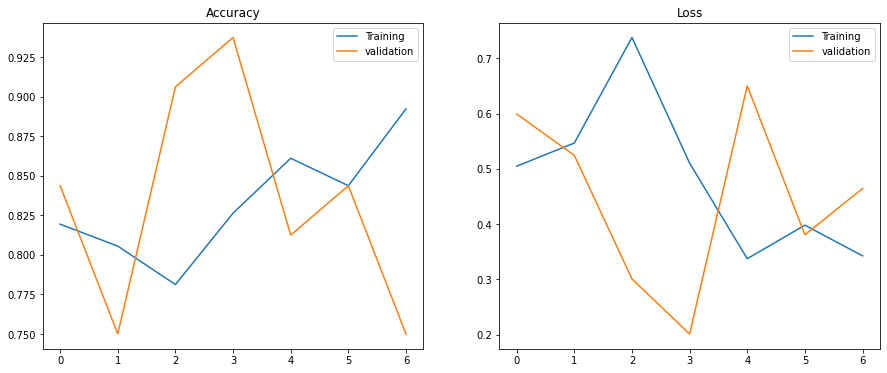

In [82]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist.epoch,hist.history['accuracy'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.epoch,hist.history['loss'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

In [84]:
modelEnd = keras.models.load_model("./Model.h5")

In [85]:
pred = modelEnd.predict(test_data, verbose=1)

365/365 [==============================] - 708s 2s/step


In [86]:
from sklearn.metrics import confusion_matrix,classification_report

predicted = [np.argmax(i) for i in pred]
confidence = [np.round((max(i)*100),2) for i in pred]

In [88]:
y_test = test_data.classes

In [91]:
classification_report(predicted,y_test)

'              precision    recall  f1-score   support\n\n           0       0.97      0.74      0.84      7590\n           1       0.66      0.95      0.78      4059\n\n    accuracy                           0.82     11649\n   macro avg       0.81      0.85      0.81     11649\nweighted avg       0.86      0.82      0.82     11649\n'

In [90]:
print(classification_report(predicted,y_test))

              precision    recall  f1-score   support

           0       0.97      0.74      0.84      7590
           1       0.66      0.95      0.78      4059

    accuracy                           0.82     11649
   macro avg       0.81      0.85      0.81     11649
weighted avg       0.86      0.82      0.82     11649



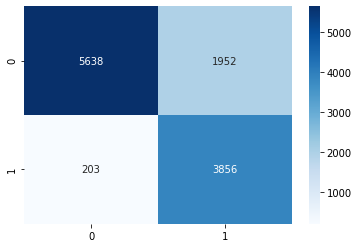

In [92]:
sns.heatmap(confusion_matrix(predicted,y_test),annot=True,fmt="d",cmap="Blues");

**Let's try on example**

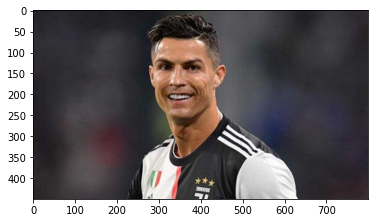

In [136]:
import cv2

img = cv2.imread("../input/ronaldo/4.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [137]:
face_cascade = cv2.CascadeClassifier("../input/haarcascade/haarcascade_frontalface_default.xml")

In [138]:
results= {0:"Female",
         1:"Male"}

face = face_cascade.detectMultiScale(img, 1.1, 7)
#face = x, y, w, h
x = face[0][0]
y = face[0][1]
w = face[0][2]
h = face[0][3]
cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 5)

img = cv2.resize(img, (96,96))
img = np.resize(img, (1,96,96,3))
result = np.argmax(model.predict(img))
results[result]

'Male'